<a href="https://colab.research.google.com/github/teamgaon/KLUE/blob/main/20220217_hj_konli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hugging Face를 활용한 Modeling
Google Colab과 Pytorch, Hugging Face Trainer를 사용하여 Model Fine-tuning과 Inference를 진행해보자

## EDA(Exploratory Data Analysis)
간단하게 Train, Test Dataset의 구조와 문장 분포를 확인해보았습니다.

### Import Package
데이터 확인을 위한 패키지 불러오기

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load Data
Data가 위치한 PATH에서 Data를 불러오기

In [3]:
PATH =  '/content/drive/MyDrive/KLUE'

train =  pd.read_csv('/content/drive/MyDrive/KorNLUDatasets-master/KorNLI/snli_1.0_train.ko.tsv', sep='\t')
test = pd.read_csv(os.path.join(PATH, 'test_data.csv'), encoding='utf-8')

train.head(5)

,sentence1,sentence2,gold_label
0,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 경쟁을 위해 말을 훈련시키고 있다.,neutral
1,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 식당에서 오믈렛을 주문하고 있다.,contradiction
2,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,사람은 야외에서 말을 타고 있다.,entailment
3,카메라에 웃고 손을 흔드는 아이들,그들은 부모님을 보고 웃고 있다,neutral
4,카메라에 웃고 손을 흔드는 아이들,아이들이 있다,entailment


In [4]:
# path = '/content/drive/MyDrive/KorNLUDatasets-master/KorNLI/'
# file = 'multinli.train.ko.tsv'
# f = open(path+file,'rt')
# reader = csv.reader(f)

# csv_list=[]
# for l in reader:
#   csv_list.append(l)
# f.close()

# df = pd.DataFrame(csv_list)

### Train, Test Data 확인

In [5]:
print(train.info(), end='\n\n')
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550152 entries, 0 to 550151
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   sentence1   550152 non-null  object
 1   sentence2   550146 non-null  object
 2   gold_label  550152 non-null  object
dtypes: object(3)
memory usage: 12.6+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1666 entries, 0 to 1665
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       1666 non-null   int64 
 1   premise     1666 non-null   object
 2   hypothesis  1666 non-null   object
 3   label       1666 non-null   object
dtypes: int64(1), object(3)
memory usage: 52.2+ KB
None


In [6]:
display(train)
display(test)

,sentence1,sentence2,gold_label
0,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 경쟁을 위해 말을 훈련시키고 있다.,neutral
1,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 식당에서 오믈렛을 주문하고 있다.,contradiction
2,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,사람은 야외에서 말을 타고 있다.,entailment
3,카메라에 웃고 손을 흔드는 아이들,그들은 부모님을 보고 웃고 있다,neutral
4,카메라에 웃고 손을 흔드는 아이들,아이들이 있다,entailment
...,...,...,...
550147,네 명의 더러운 맨발의 아이들.,4명의 아이들이 '가장 깨끗한 발'로 상을 받았다,contradiction
550148,네 명의 더러운 맨발의 아이들.,네 명의 노숙자 아이들이 신발을 도둑맞아서 그들의 발이 더러워졌다.,neutral
550149,한 남자가 아름다운 푸른 물에서 바디슈트를 입고 서핑을 하고 있다.,바디슈트를 입은 남자가 서핑 대회에 참가하고 있다.,neutral
550150,한 남자가 아름다운 푸른 물에서 바디슈트를 입고 서핑을 하고 있다.,비즈니스 슈트를 입은 남자가 이사회로 향하고 있다.,contradiction


,index,premise,hypothesis,label
0,0,다만 조금 좁아서 케리어를 펼치기 불편합니다.,케리어를 펼치기에 공간이 충분했습니다.,answer
1,1,그리고 위치가 시먼역보다는 샤오난먼역에 가까워요,시먼역보다는 샤오난먼역에 먼저 도착할 수 있어요,answer
2,2,구구절절 설명하고 이해시키려는 노력이 큰 의미없이 다가온다.,무엇인가 말을 많이 하기는 했지만 큰 의미가 있지는 않았다.,answer
3,3,몇 번을 다시봐도 볼 때마다 가슴이 저민다.,다시 봤을때는 무덤덤했다.,answer
4,4,"8월 중에 입주신청을 하면 청년은 9월, 신혼부부는 10월부터 입주가 가능하다.",8월 중에 입주신청을 하면 신혼부부는 9월 부터 입주가 가능하다.,answer
...,...,...,...,...
1661,1661,"또 작업자의 숙련도와 경험 향상, 전문성을 요구하는 난이도 높은 데이터 가공을 통해...",이미지 데이터를 가공하는 것이 가장 난이도가 높다.,answer
1662,1662,결말을 보니 아무래도 이 영화는 2부가 계획된 듯 합니다.,결말을 보니 분명히 2편이 나올것이 틀림없다.,answer
1663,1663,사회적 거리 두기 상황에서 총리도 카페를 갔다가 자리가 없어서 퇴짜 맞은 일도 있을...,사회적 거리두기 상황에서는 고위관직자도 방역지침을 준수해야 한다.,answer
1664,1664,로마에서 3박4일간 이곳에서 머물렀습니다.,이곳에서 머무르며 로마의 명소들을 방문했습니다.,answer


In [7]:
train = train.dropna()

In [8]:
train = train.reset_index(drop=True)

In [9]:
train['index'] = train.index

In [10]:
train.rename(columns = {'sentence1':'premise','sentence2':'hypothesis','gold_label':'label'},inplace=True)
train

,premise,hypothesis,label,index
0,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 경쟁을 위해 말을 훈련시키고 있다.,neutral,0
1,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 식당에서 오믈렛을 주문하고 있다.,contradiction,1
2,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,사람은 야외에서 말을 타고 있다.,entailment,2
3,카메라에 웃고 손을 흔드는 아이들,그들은 부모님을 보고 웃고 있다,neutral,3
4,카메라에 웃고 손을 흔드는 아이들,아이들이 있다,entailment,4
...,...,...,...,...
550141,네 명의 더러운 맨발의 아이들.,4명의 아이들이 '가장 깨끗한 발'로 상을 받았다,contradiction,550141
550142,네 명의 더러운 맨발의 아이들.,네 명의 노숙자 아이들이 신발을 도둑맞아서 그들의 발이 더러워졌다.,neutral,550142
550143,한 남자가 아름다운 푸른 물에서 바디슈트를 입고 서핑을 하고 있다.,바디슈트를 입은 남자가 서핑 대회에 참가하고 있다.,neutral,550143
550144,한 남자가 아름다운 푸른 물에서 바디슈트를 입고 서핑을 하고 있다.,비즈니스 슈트를 입은 남자가 이사회로 향하고 있다.,contradiction,550144


In [11]:
print('Train Columns: ', train.columns)
print('Test Columns: ', test.columns)

Train Columns:  Index(['premise', 'hypothesis', 'label', 'index'], dtype='object')
Test Columns:  Index(['index', 'premise', 'hypothesis', 'label'], dtype='object')


In [12]:
print('Train Label: ', train['label'].value_counts(), sep='\n', end='\n\n')
print('Test Label: ', test['label'].value_counts(), sep='\n')

Train Label: 
neutral          183382
contradiction    183382
entailment       183382
Name: label, dtype: int64

Test Label: 
answer    1666
Name: label, dtype: int64


In [13]:
print('Train Null: ', train.isnull().sum(), sep='\n', end='\n\n')
print('Test Null: ', test.isnull().sum(), sep='\n')

Train Null: 
premise       0
hypothesis    0
label         0
index         0
dtype: int64

Test Null: 
index         0
premise       0
hypothesis    0
label         0
dtype: int64


### Label 분포
Train Dataset의 Label 분포를 Bar Chart를 사용하여 시각화

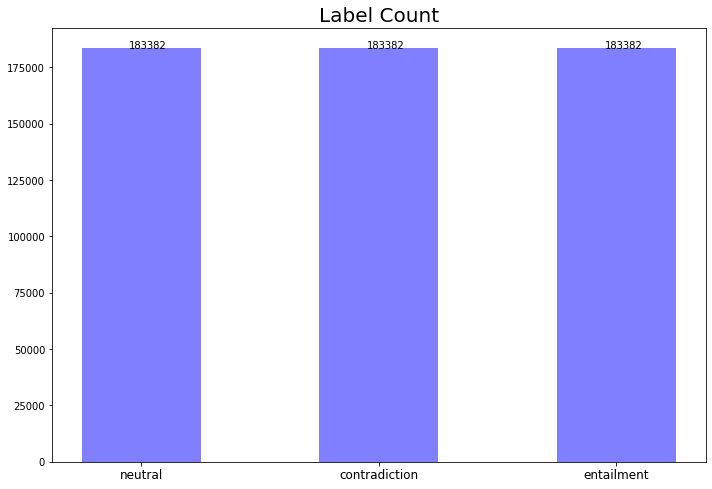

In [14]:
feature = train['label']

plt.figure(figsize=(10,7.5))
plt.title('Label Count', fontsize=20)

temp = feature.value_counts()
plt.bar(temp.keys(), temp.values, width=0.5, color='b', alpha=0.5)
plt.text(-0.05, temp.values[0]+20, s=temp.values[0])
plt.text(0.95, temp.values[1]+20, s=temp.values[1])
plt.text(1.95, temp.values[2]+20, s=temp.values[2])

plt.xticks(temp.keys(), fontsize=12) # x축 값, 폰트 크기 설정
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 레이아웃 설정
plt.show() # 그래프 나타내기

### 전제, 가설 길이 확인
Train에 존재하는 Premise(전제), Hypothesis(가설)의 길이를 확인하고 이를 통해 Tokenizer의 max_length 설정이 가능

In [15]:
max_len = np.max(train['premise'].str.len())
min_len = np.min(train['premise'].str.len())
mean_len = np.mean(train['premise'].str.len())

print('Max Premise Length: ', max_len)
print('Min Premise Length: ', min_len)
print('Mean Premise Lenght: ', mean_len, '\n')

max_len = np.max(train['hypothesis'].str.len())
min_len = np.min(train['hypothesis'].str.len())
mean_len = np.mean(train['hypothesis'].str.len())

print('Max Hypothesis Length: ', max_len)
print('Min Hypothesis Length: ', min_len)
print('Mean Hypothesis Lenght: ', mean_len)

Max Premise Length:  188
Min Premise Length:  3
Mean Premise Lenght:  33.33275894035401 

Max Hypothesis Length:  153
Min Hypothesis Length:  1
Mean Hypothesis Lenght:  19.66392012302189


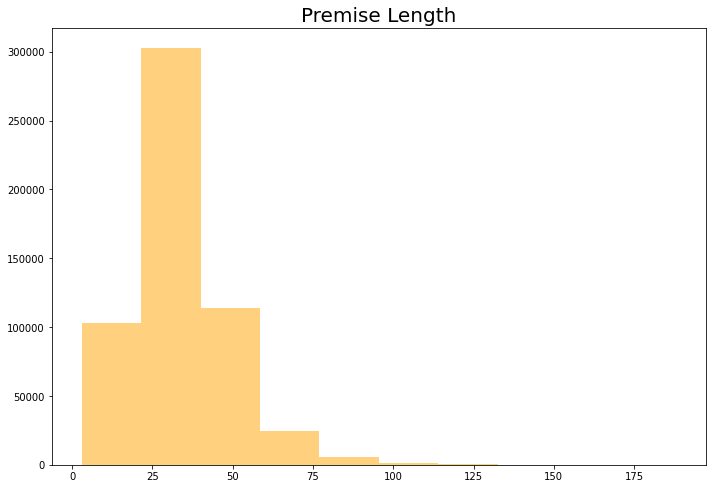

In [16]:
from collections import Counter

plt.figure(figsize=(10,7.5))
plt.title('Premise Length', fontsize=20)

plt.hist(train['premise'].str.len(), alpha=0.5, color='orange')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 레이아웃 설정

plt.show()

### 간단한 Test Preprocessing
전제, 가설에 존재하는 한글 단어가 아닌 다른 단어들은 전부 제거해줍니다.

In [17]:
train['premise'] = train['premise'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]', '')
test['premise'] = test['premise'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]", "")
train.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,premise,hypothesis,label,index
0,말을 탄 사람이 고장난 비행기 위로 뛰어오른다,한 사람이 경쟁을 위해 말을 훈련시키고 있다.,neutral,0
1,말을 탄 사람이 고장난 비행기 위로 뛰어오른다,한 사람이 식당에서 오믈렛을 주문하고 있다.,contradiction,1
2,말을 탄 사람이 고장난 비행기 위로 뛰어오른다,사람은 야외에서 말을 타고 있다.,entailment,2
3,카메라에 웃고 손을 흔드는 아이들,그들은 부모님을 보고 웃고 있다,neutral,3
4,카메라에 웃고 손을 흔드는 아이들,아이들이 있다,entailment,4


In [18]:
train['hypothesis'] = train['hypothesis'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]', '')
test['hypothesis'] = test['hypothesis'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]", "")
train.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,premise,hypothesis,label,index
0,말을 탄 사람이 고장난 비행기 위로 뛰어오른다,한 사람이 경쟁을 위해 말을 훈련시키고 있다,neutral,0
1,말을 탄 사람이 고장난 비행기 위로 뛰어오른다,한 사람이 식당에서 오믈렛을 주문하고 있다,contradiction,1
2,말을 탄 사람이 고장난 비행기 위로 뛰어오른다,사람은 야외에서 말을 타고 있다,entailment,2
3,카메라에 웃고 손을 흔드는 아이들,그들은 부모님을 보고 웃고 있다,neutral,3
4,카메라에 웃고 손을 흔드는 아이들,아이들이 있다,entailment,4


## Modeling

### Download transformers and Import Package

In [19]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 7.8 MB/s 
     |████████████████████████████████| 596 kB 74.8 MB/s 
     |████████████████████████████████| 67 kB 782 kB/s 
     |████████████████████████████████| 6.8 MB 59.2 MB/s 
     |████████████████████████████████| 895 kB 74.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [20]:
import os
import random
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification, AutoConfig, AutoTokenizer

### Seed 고정, GPU 설정

In [21]:
def seed_everything(seed:int = 1004):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(42)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Load Tokenizer, Model
Hugging Face Hub에 존재하는 Pretrained Tokenizer와 Model 및 Model Config를 불러옵니다.

이 때, Classification은 num_labels가 2로 Default되어있기 때문에 Model Config의 Parameter를 변경해줍니다.

In [22]:
MODEL_NAME = 'klue/roberta-base'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

config = AutoConfig.from_pretrained(MODEL_NAME)
config.num_labels = 3

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)

print(model)
print(config)

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/734k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/546 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classif

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

### Tokenizing
Train Data를 Train과 Validation Dataset으로 나누고 각각 데이터를 Tokenizer를 통해 Tokenizing을 합니다.

Tokenizer에 들어가는 문장은 전제와 가설을 Concat한 문장이 됩니다.

In [23]:
train_dataset, eval_dataset = train_test_split(train, test_size=0.2, shuffle=True, stratify=train['label'])

tokenized_train = tokenizer(
    list(train['premise']),
    list(train['hypothesis']),
    return_tensors="pt",
    max_length=128, # Max_Length = 190
    padding=True,
    truncation=True,
    add_special_tokens=True
)

tokenized_eval = tokenizer(
    list(eval_dataset['premise']),
    list(eval_dataset['hypothesis']),
    return_tensors="pt",
    max_length=128,
    padding=True,
    truncation=True,
    add_special_tokens=True
)

print(tokenized_train['input_ids'][0])
print(tokenizer.decode(tokenized_train['input_ids'][0]))

tensor([    0,  1041,  2069,  1763,  3611,  2052,  8514,  2336,  7046,  7587,
         5603, 17290,  2062,     2,  1891,  3611,  2052,  3855,  2069,  3627,
         1041,  2069,  4484,  2067,  2089,  2088,  1513,  2062,     2,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1])
[CLS] 말을 탄 사람이 고장난 비

In [24]:
class BERTDataset(torch.utils.data.Dataset):
    def __init__(self, pair_dataset, label):
        self.pair_dataset = pair_dataset
        self.label = label

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.pair_dataset.items()}
        item['label'] = torch.tensor(self.label[idx])
        
        return item

    def __len__(self):
        return len(self.label)

In [25]:
def label_to_num(label):
    label_dict = {"entailment": 0, "contradiction": 1, "neutral": 2, "answer": 3}
    num_label = []

    for v in label:
        num_label.append(label_dict[v])
    
    return num_label


train_label = label_to_num(train_dataset['label'].values)
eval_label = label_to_num(eval_dataset['label'].values)

In [26]:
train_dataset = BERTDataset(tokenized_train, train_label)
eval_dataset = BERTDataset(tokenized_eval, eval_label)

print(train_dataset.__len__())
print(train_dataset.__getitem__(19997))
print(tokenizer.decode(train_dataset.__getitem__(19997)['input_ids']))

440116
{'input_ids': tensor([    0,  4517,  2897, 17968,  2138,  5681,  2205,  2259,   575,  6233,
         3783,  2259,   752,  8918,  3997,     2,  3997,  2031,  2073,  8446,
         2062,     2,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1])

In [27]:
def compute_metrics(pred):
  """ validation을 위한 metrics function """
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  probs = pred.predictions

  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds) # 리더보드 평가에는 포함되지 않습니다.

  return {
      'accuracy': acc,
  }

In [28]:
training_ars = TrainingArguments(
    output_dir='./result',
    num_train_epochs=10,
    per_device_train_batch_size=32,
    save_total_limit=5,
    save_steps=500,
    evaluation_strategy='steps',
    eval_steps = 500,
    load_best_model_at_end = True,
)

trainer = Trainer(
    model=model,
    args=training_ars,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()
model.save_pretrained('./result/best_model')

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 440116
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 137540


Step,Training Loss,Validation Loss


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Tokenizer_NAME = "klue/roberta-large"
tokenizer = AutoTokenizer.from_pretrained(Tokenizer_NAME)

MODEL_NAME = './result/checkpoint-5000'
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.resize_token_embeddings(tokenizer.vocab_size)
model.to(device)

print(tokenizer)

In [ ]:
test_label = label_to_num(test['label'].values)

tokenized_test = tokenizer(
    list(test['premise']),
    list(test['hypothesis']),
    return_tensors="pt",
    max_length=128,
    padding=True,
    truncation=True,
    add_special_tokens=True
)

test_dataset = BERTDataset(tokenized_test, test_label)

print(test_dataset.__len__())
print(test_dataset.__getitem__(1665))
print(tokenizer.decode(test_dataset.__getitem__(6)['input_ids']))

In [ ]:
dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
output_pred = []
output_prob = []

for i, data in enumerate(tqdm(dataloader)):
    with torch.no_grad():
        outputs = model(
            input_ids=data['input_ids'].to(device),
            attention_mask=data['attention_mask'].to(device),
            token_type_ids=data['token_type_ids'].to(device)
        )
    logits = outputs[0]
    prob = F.softmax(logits, dim=-1).detach().cpu().numpy()
    logits = logits.detach().cpu().numpy()
    result = np.argmax(logits, axis=-1)

    output_pred.append(result)
    output_prob.append(prob)
  
pred_answer, output_prob = np.concatenate(output_pred).tolist(), np.concatenate(output_prob, axis=0).tolist()
print(pred_answer)

In [ ]:
def num_to_label(label):
    label_dict = {0: "entailment", 1: "contradiction", 2: "neutral"}
    str_label = []

    for i, v in enumerate(label):
        str_label.append([i,label_dict[v]])
    
    return str_label

answer = num_to_label(pred_answer)
print(answer)

In [ ]:
df = pd.DataFrame(answer, columns=['index', 'label'])

df.to_csv('./result/submission.csv', index=False)

print(df)